In [1]:
import duckdb

con = duckdb.connect("bluebikes_2015_2025.duckdb")

df_bike = con.execute("""
    SELECT *
    FROM trips_weather_interpolated
    WHERE weather_time >= '2024-08-01'
      AND weather_time <  '2025-08-01';
""").df()

con.close()

df_bike


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,_id,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,snow_depth,snowfall,surface_pressure,surface_solar_radiation_downwards,surface_thermal_radiation_downwards,total_cloud_cover,total_precipitation,wind_speed,wind_direction,relative_humidity
0,22896641,7E24B4B0764A6DB9,classic_bike,2024-08-01 19:57:49.371,2024-08-01 20:18:30.073,Mass Ave/Lafayette Square,M32085,30 Dane St,S32023,42.363565,...,0.0,0.0,1006.624260,481.372266,425.828266,32.658987,0.001833,2.863855,261.353815,53.812342
1,22896642,8E582C8F627CDA7A,classic_bike,2024-08-01 19:57:49.672,2024-08-01 20:00:29.709,Harvard St and Stedman St,K32017,Harvard Ave at Brainerd Rd,D32035,42.344352,...,0.0,0.0,1006.407306,498.610293,426.390594,31.356240,0.001766,2.961599,263.853988,53.200875
2,22896643,80F4BEC5E5E129F7,classic_bike,2024-08-01 19:57:49.879,2024-08-01 20:06:13.238,Columbus Ave at W. Canton St,C32077,Washington St at Lenox St,C32005,42.344742,...,0.0,0.0,1006.981328,492.431969,425.846754,31.509788,0.002121,2.866257,259.846432,54.572623
3,22896644,51072E402B39A9E1,electric_bike,2024-08-01 19:57:50.859,2024-08-01 20:07:48.755,Encore,V32005,Assembly Square T,S32018,42.393293,...,0.0,0.0,1006.917728,487.901522,425.621446,31.542836,0.002219,2.772315,259.395505,54.926817
4,22896645,AF26641BDD824782,classic_bike,2024-08-01 19:57:53.774,2024-08-01 20:05:44.461,Boston City Hall - 28 State St,B32008,Harrison Ave at Bennet St,D32043,42.358920,...,0.0,0.0,1007.161602,491.659293,425.602099,31.394071,0.002305,2.806542,258.336306,55.201633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4702175,27115516,51377D3F00B51DB7,classic_bike,2025-07-05 13:01:27.016,2025-07-05 13:52:22.219,Harvard University River Houses at DeWolfe St ...,M32038,Harvard University River Houses at DeWolfe St ...,M32038,42.369239,...,0.0,0.0,1017.001320,573.112042,325.397992,60.819834,0.000000,1.587514,256.803951,55.507629
4702176,27115517,736687BADEB67748,classic_bike,2025-07-05 13:01:27.268,2025-07-05 13:06:57.380,Central Square at Mass Ave / Essex St,M32011,Cambridge Dept. of Public Works -147 Hampshire...,M32052,42.365070,...,0.0,0.0,1017.258355,511.650769,323.496521,37.587279,0.000000,1.679393,263.916273,59.541137
4702177,27115518,AB366079DE3D9318,classic_bike,2025-07-05 13:01:29.846,2025-07-05 13:46:25.015,Elevate at One Leighton,M32092,Union Square Station,S32054,42.369931,...,0.0,0.0,1017.400181,566.476070,324.913953,56.196114,0.000000,1.655333,257.768151,56.713396
4702178,27115519,64E58DD7A364D1DC,classic_bike,2025-07-05 13:01:43.048,2025-07-05 13:18:37.112,Clarendon Hill at Broadway,S32010,Mass Ave at Alewife Greenway,L320013,42.406302,...,0.0,0.0,1016.784659,527.572614,323.729006,48.399202,0.000000,1.636059,261.912797,58.331883


In [82]:
df_bike.start_station_id.value_counts()


start_station_id
M32006    84749
M32011    64929
M32042    57341
M32018    56356
M32041    44726
          ...  
D32073       43
D32074       12
D32003       11
B32066        9
D32075        3
Name: count, Length: 572, dtype: int64

<Axes: xlabel='start_station_id', ylabel='Count'>

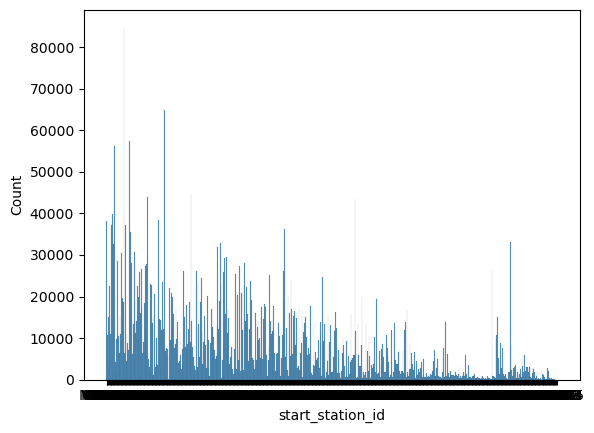

In [83]:
import seaborn as sns
sns.histplot(df_bike,x="start_station_id")

In [28]:
len(df_bike.start_station_id.value_counts().values<5000)


572

In [29]:
df_bike.start_station_id.value_counts().values
i = df_bike.start_station_id.value_counts().values

sum(i>2000)

np.int64(382)

In [63]:
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", 50)


# City-Level Weather Impact on Bike Usage


In [2]:
!pip install xgboost
!pip install folium



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import folium




In [4]:
df_bike.columns

Index(['_id', 'ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'tripduration', 'postal_code', 'birth_year', 'gender',
       'weather_time', 'weather_lat', 'weather_lon', '10m_u_component_of_wind',
       '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature',
       'instantaneous_10m_wind_gust', 'precipitation_type', 'snow_depth',
       'snowfall', 'surface_pressure', 'surface_solar_radiation_downwards',
       'surface_thermal_radiation_downwards', 'total_cloud_cover',
       'total_precipitation', 'wind_speed', 'wind_direction',
       'relative_humidity'],
      dtype='object')

In [5]:
# Select start station columns and rename them to common names
start_stations = df_bike[[
    "start_station_id", "start_station_name", "start_lat", "start_lng"
]].rename(columns={
    "start_station_id": "station_id",       # rename to a general station ID
    "start_station_name": "station_name",   # rename to a general station name
    "start_lat": "lat",                     # rename latitude
    "start_lng": "lng"                      # rename longitude
})

# Select end station columns and rename them to the same common names
end_stations = df_bike[[
    "end_station_id", "end_station_name", "end_lat", "end_lng"
]].rename(columns={
    "end_station_id": "station_id",         # rename to match start table
    "end_station_name": "station_name",     # rename to match start table
    "end_lat": "lat",                       # rename latitude
    "end_lng": "lng"                        # rename longitude
})

# Combine start and end station tables together
all_stations = pd.concat([start_stations, end_stations])

# Remove duplicate stations based on station_id (keep only unique ones)
unique_stations = all_stations.drop_duplicates(subset=["station_id"])

# Print the total number of unique stations
print("Total number of unique stations:", len(unique_stations))

# Show the first few rows of unique stations
unique_stations.head()


Total number of unique stations: 572


,station_id,station_name,lat,lng
0,M32085,Mass Ave/Lafayette Square,42.363565,-71.100442
1,K32017,Harvard St and Stedman St,42.344352,-71.124904
2,C32077,Columbus Ave at W. Canton St,42.344742,-71.076482
3,V32005,Encore,42.393293,-71.072448
4,B32008,Boston City Hall - 28 State St,42.358920,-71.057629


This code collects information about all bike stations from the trip dataset. First, it takes the start-station columns and renames them to a common naming format. Then it does the same for the end-station columns. After that, it combines both tables into one list because some stations appear only as start or only as end. Since many stations repeat in the dataset, the code removes duplicates using the station ID. Finally, it prints how many unique stations exist and shows the first few rows.

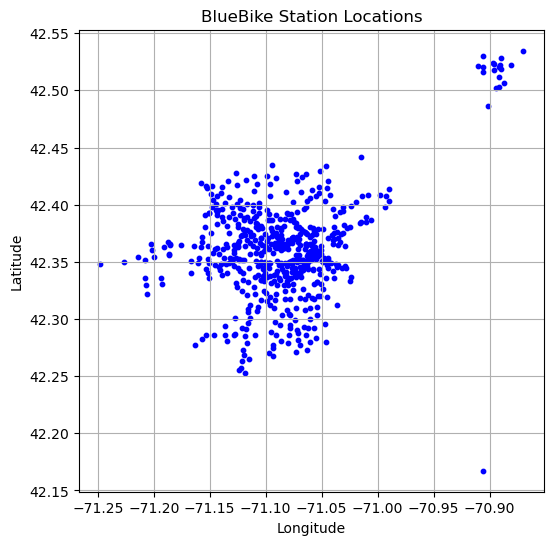

In [6]:
# Create a small square figure for the map
plt.figure(figsize=(6, 6))

# Plot all station points on the map (longitude on x-axis, latitude on y-axis)
plt.scatter(
    unique_stations["lng"],   # x-axis values
    unique_stations["lat"],   # y-axis values
    s=10,                     # size of each dot
    color="blue"              # dot color
)

# Add a title to the plot
plt.title("BlueBike Station Locations")

# Label the x and y axes
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a light grid to the background
plt.grid(True)

# Show the plot
plt.show()


This code creates a scatter plot that shows all the BlueBike station locations on a map. It uses longitude values for the x-axis and latitude for the y-axis, so each point represents one station. The figure size is set to 6×6 to look like a square map. The dots are small and blue, and the plot includes labels, a title, and a background grid to make the map easier to read. Finally, plt.show() displays the map.

===== Wind Speed Stats =====
count    4.700520e+06
mean     3.516451e+00
std      1.680220e+00
min      6.190592e-04
25%      2.298510e+00
50%      3.346327e+00
75%      4.573138e+00
max      1.186325e+01
Name: wind_speed, dtype: float64

===== Total Precipitation Stats =====
count    4.700520e+06
mean     7.890320e-02
std      3.272338e-01
min     -3.725290e-06
25%      0.000000e+00
50%      1.862645e-06
75%      8.974560e-03
max      1.138578e+01
Name: total_precipitation, dtype: float64


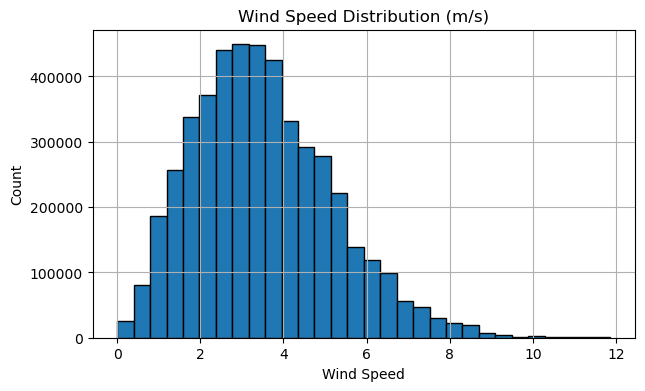

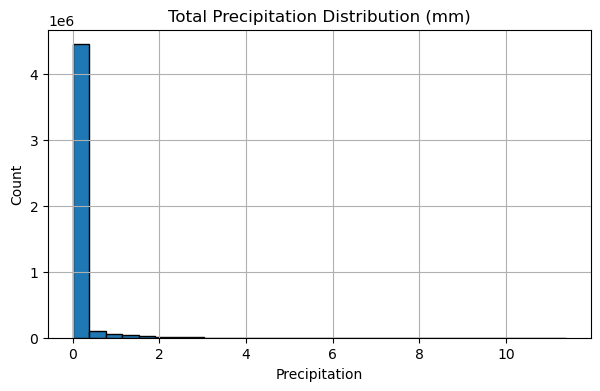

In [7]:
# 1) Print basic statistics for wind speed
print("===== Wind Speed Stats =====")
print(df_bike["wind_speed"].describe())   # shows mean, min, max, quartiles

#  2) Print basic statistics for precipitation
print("\n===== Total Precipitation Stats =====")
print(df_bike["total_precipitation"].describe())  # statistical summary

# 3) Histogram of wind speed
plt.figure(figsize=(7,4))                  # set size of the plot
plt.hist(df_bike["wind_speed"], bins=30, edgecolor='black')  # draw histogram
plt.title("Wind Speed Distribution (m/s)") # title of the chart
plt.xlabel("Wind Speed")                   # x-axis label
plt.ylabel("Count")                        # y-axis label
plt.grid(True)                             # add grid lines
plt.show()                                 # display the plot

# 4) Histogram of precipitation
plt.figure(figsize=(7,4))                  # set size of the plot
plt.hist(df_bike["total_precipitation"], bins=30, edgecolor='black')  # draw histogram
plt.title("Total Precipitation Distribution (mm)")  # title of the chart
plt.xlabel("Precipitation")                # x-axis label
plt.ylabel("Count")                        # y-axis label
plt.grid(True)                             # add grid lines
plt.show()                                 # display the plot


This code first prints summary statistics for wind speed and precipitation, such as the average, minimum, maximum, and quartiles. After that, it creates two histograms: one for wind speed and one for total precipitation. Each histogram shows how the values are distributed and how often different levels appear in the dataset. The plots include grid lines, labels, and titles to make them easy to read. In short, this code helps you quickly understand the overall weather patterns in your bike dataset.

In [8]:
# Convert the weather_time column to a real datetime type
df_bike["time_hour"] = pd.to_datetime(df_bike["weather_time"]).dt.floor("h")

# Extract the hour of the day (0–23)
df_bike["hour"] = df_bike["time_hour"].dt.hour

# Extract the day of the month (1–31)
df_bike["day"] = df_bike["time_hour"].dt.day

# Extract the weekday number (0 = Monday, 6 = Sunday)
df_bike["weekday"] = df_bike["time_hour"].dt.dayofweek

# Create a weekend flag (1 = weekend, 0 = weekday)
df_bike["is_weekend"] = df_bike["weekday"].isin([5, 6]).astype(int)

# Create a windy day flag (1 = wind speed > 6 m/s)
df_bike["windy_day"] = (df_bike["wind_speed"] > 6).astype(int)

# Create a rainy day flag (1 = total_precipitation > 0.5 mm)
df_bike["rainy_day"] = (df_bike["total_precipitation"] > 0.5).astype(int)

# Create a snowy day flag (1 = precipitation_type == 3)
df_bike["snowy_day"] = df_bike["precipitation_type"].isin([3]).astype(int)

# Show example rows
df_bike[[
    "time_hour", "hour", "day", "weekday", "is_weekend",
    "wind_speed", "windy_day",
    "total_precipitation", "rainy_day",
    "precipitation_type", "snowy_day"
]].head()


,time_hour,hour,day,weekday,is_weekend,wind_speed,windy_day,total_precipitation,rainy_day,precipitation_type,snowy_day
0,2024-08-01 20:00:00,20,1,3,0,2.863855,0,0.001833,0,0.0,0
1,2024-08-01 19:00:00,19,1,3,0,2.961599,0,0.001766,0,0.0,0
2,2024-08-01 20:00:00,20,1,3,0,2.866257,0,0.002121,0,0.0,0
3,2024-08-01 20:00:00,20,1,3,0,2.772315,0,0.002219,0,0.0,0
4,2024-08-01 20:00:00,20,1,3,0,2.806542,0,0.002305,0,0.0,0


This code creates several new features from the timestamp and weather variables. First, it converts the time_hour column into a real datetime object so we can extract useful time information. Then it creates new columns for hour, day, weekday, and a weekend flag. After that, it adds simple weather indicators: a windy day (wind speed above 6 m/s), a rainy day (precipitation above 0.5 mm), and a snowy day (precipitation type equal to 3). Finally, it prints the first few rows to check the new features. These new variables help us analyze how bike usage changes with time and weather.

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# Group the bike data by each hour (time_hour)
df_hourly = df_bike.groupby("time_hour").agg({
    "ride_id": "count",          # count how many trips happened in this hour
    "hour": "first",             # keep the hour value
    "day": "first",              # keep the day of the month
    "weekday": "first",          # keep the weekday number
    "is_weekend": "first",       # keep weekend flag
    "wind_speed": "mean",        # average wind speed in this hour
    "windy_day": "max",          # if ANY minute was windy → mark hour as windy
    "total_precipitation": "mean",  # average precipitation in this hour
    "rainy_day": "max",          # if it rained at any time in this hour → mark as rainy
    "precipitation_type": "max", # highest precipitation type in the hour
    "snowy_day": "max",           # if it snowed at any point → mark as snowy
    "2m_temperature": "mean"
   

}).reset_index()

# Rename the trip count column
df_hourly = df_hourly.rename(columns={"ride_id": "trips"})

# ---- Add Holiday Feature (after groupby) ----
cal = calendar()
holidays = cal.holidays(
    start=df_hourly["time_hour"].min(),
    end=df_hourly["time_hour"].max()
)
# 1 = holiday, 0 = normal day
df_hourly["is_holiday"] = df_hourly["time_hour"].dt.normalize().isin(holidays).astype(int)


# Make sure month exists
df_hourly["month"] = df_hourly["time_hour"].dt.month
df_hourly["season"] = pd.cut(
    df_hourly["month"],
    bins=[0, 2, 5, 8, 11, 12],
    labels=["Winter", "Spring", "Summer", "Fall", "Winter"],
    right=True,
    ordered=False   
)

df_hourly = pd.get_dummies(df_hourly, columns=["season"])
df_hourly = df_hourly.dropna()

# Show the first 30 rows
df_hourly.head()


,time_hour,trips,hour,day,weekday,is_weekend,wind_speed,windy_day,total_precipitation,rainy_day,precipitation_type,snowy_day,2m_temperature,is_holiday,month,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-08-01 00:00:00,135,0,1,3,0,4.467081,0,0.128778,0,1.000046,0,23.859295,0,8,False,False,True,False
1,2024-08-01 01:00:00,80,1,1,3,0,4.212774,0,0.647372,1,1.000046,0,23.597325,0,8,False,False,True,False
2,2024-08-01 02:00:00,33,2,1,3,0,4.131097,0,0.731798,1,1.000046,0,23.228444,0,8,False,False,True,False
3,2024-08-01 03:00:00,21,3,1,3,0,4.179396,0,0.233656,0,0.965979,0,23.162022,0,8,False,False,True,False
4,2024-08-01 04:00:00,31,4,1,3,0,3.955337,0,0.003258,0,0.817334,0,23.171896,0,8,False,False,True,False


In [39]:
df_hourly["is_holiday"].value_counts()



is_holiday
0    8495
1     264
Name: count, dtype: int64

### Average trips (normal days vs rainy days)

This code takes your bike dataset and summarizes it by each hour. It groups all trips that happened within the same hour and calculates useful statistics, such as the total number of trips, the average wind speed, and the average precipitation. It also creates hourly weather indicators like windy, rainy, or snowy, based on whether any of those conditions happened during that hour. By doing this, you turn very detailed minute-level data into clean hourly features that are perfect for charts and machine learning models.

Average trips (normal vs rainy):
rainy_day
0    552.013651
1    380.264858
Name: trips, dtype: float64

Absolute difference in trips (no rain - rain): 171.75
Percentage drop on rainy hours: 31.11%


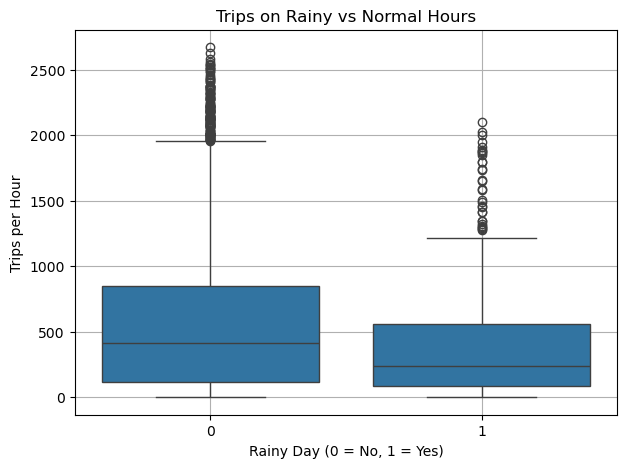

In [138]:

# ----- 1) Find the average number of trips for rainy vs non-rainy hours -----
# Group by rainy_day (0 = no rain, 1 = rain) and calculate the mean of trips
mean_trips_by_rain = df_hourly.groupby("rainy_day")["trips"].mean()

print("Average trips (normal vs rainy):")
print(mean_trips_by_rain)

# Save the values in variables for easier calculations
avg_no_rain = mean_trips_by_rain[0]   # average trips when it is NOT raining
avg_rain    = mean_trips_by_rain[1]   # average trips when it IS raining

# ----- 2) Calculate how much trips change on rainy hours -----
# Absolute change in average trips
diff_abs = avg_no_rain - avg_rain

# Percentage drop compared to normal (no rain) hours
diff_pct = (diff_abs / avg_no_rain) * 100

print(f"\nAbsolute difference in trips (no rain - rain): {diff_abs:.2f}")
print(f"Percentage drop on rainy hours: {diff_pct:.2f}%")

# ----- 3) Create a boxplot to compare rainy vs non-rainy hours -----
plt.figure(figsize=(7,5))

# Boxplot showing the distribution of trips for 0 (no rain) and 1 (rain)
sns.boxplot(x="rainy_day", y="trips", data=df_hourly)

plt.title("Trips on Rainy vs Normal Hours")   # chart title
plt.xlabel("Rainy Day (0 = No, 1 = Yes)")      # label for x-axis
plt.ylabel("Trips per Hour")                   # label for y-axis
plt.grid(True)                                 # add background grid
plt.show()                                     # show the plot


This code compares how bike usage changes during rainy hours versus normal hours. First, it calculates the average number of hourly trips for both rainy and non-rainy hours. Then it computes how much the number of trips drops when it rains, both as an absolute difference and as a percentage. Finally, the boxplot visualizes the distribution of trips in both conditions, helping us easily see how rain affects rider behavior. This analysis makes it clear whether rain reduces bike usage and by how much.

### Average trips (weekday vs weekend)

Average trips (weekday vs weekend):
is_weekend
0    562.478844
1    472.495593
Name: trips, dtype: float64
Weekdays have 16.00% more trips than weekends.
Percentage change on weekends: 16.00%


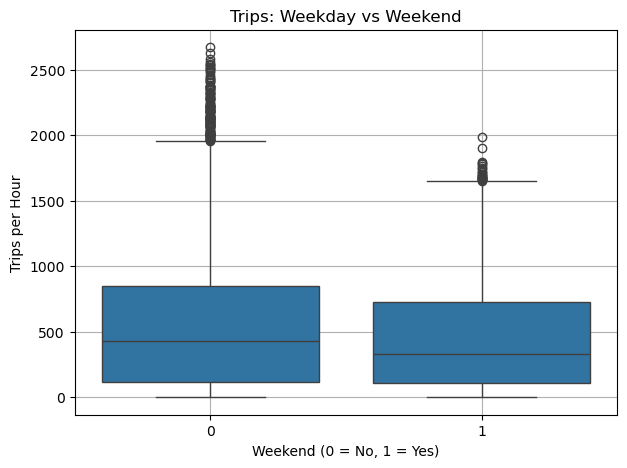

In [86]:
# ----- 1) Compute average trips for weekday vs weekend -----
# Group by is_weekend (0 = weekday, 1 = weekend)
mean_trips_weekend = df_hourly.groupby("is_weekend")["trips"].mean()

print("Average trips (weekday vs weekend):")
print(mean_trips_weekend)

# Extract values for clarity
avg_weekday = mean_trips_weekend[0]   # average trips on weekdays
avg_weekend = mean_trips_weekend[1]   # average trips on weekends

# ----- 2) Compute absolute and percentage difference -----
diff_abs_we = avg_weekday - avg_weekend     # weekday minus weekend
diff_pct_we = (diff_abs_we / avg_weekday) * 100

print(f"Weekdays have {diff_pct_we:.2f}% more trips than weekends.")
print(f"Percentage change on weekends: {diff_pct_we:.2f}%")

# ----- 3) Boxplot to visualize weekend vs weekday -----
plt.figure(figsize=(7,5))
sns.boxplot(x="is_weekend", y="trips", data=df_hourly)

plt.title("Trips: Weekday vs Weekend")
plt.xlabel("Weekend (0 = No, 1 = Yes)")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()

In this code, we compared the average number of bike trips between weekdays (0) and weekends (1). We calculated the average trips for both groups and then measured the difference and the percentage change. After that, we created a simple boxplot that visually shows how bike usage changes on weekends. This analysis helps us understand whether people use BlueBikes more during weekends, which usually reflects leisure, recreation, and non-work travel patterns.

### Average trips (normal days vs Holiday days)


Average trips (normal days vs holidays):
is_holiday
0    541.655798
1    381.772727
Name: trips, dtype: float64

Absolute difference in trips (normal - holiday): 159.88
Percentage drop on holidays: 29.52%


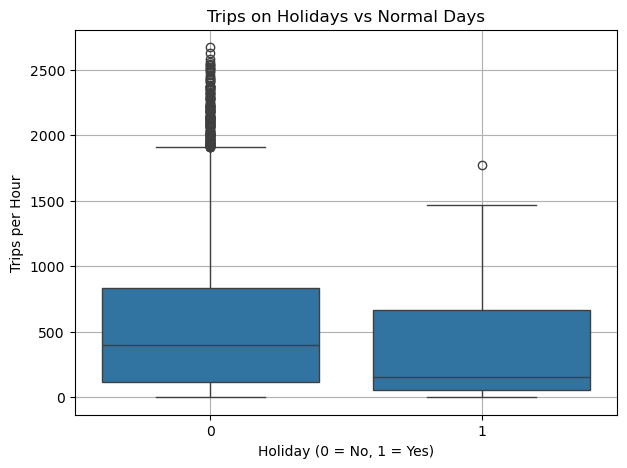

In [140]:
# ----- 1) Compute average trips for holidays vs normal days -----
mean_trips_by_holiday = df_hourly.groupby("is_holiday")["trips"].mean()

print("Average trips (normal days vs holidays):")
print(mean_trips_by_holiday)

avg_normal_day = mean_trips_by_holiday[0]   # NOT a holiday
avg_holiday    = mean_trips_by_holiday[1]   # holiday

# ----- 2) Difference -----
diff_abs_hol = avg_normal_day - avg_holiday
diff_pct_hol = (diff_abs_hol / avg_normal_day) * 100

print(f"\nAbsolute difference in trips (normal - holiday): {diff_abs_hol:.2f}")
print(f"Percentage drop on holidays: {diff_pct_hol:.2f}%")

# ----- 3) Boxplot for holidays -----
plt.figure(figsize=(7,5))
sns.boxplot(x="is_holiday", y="trips", data=df_hourly)

plt.title("Trips on Holidays vs Normal Days")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()


### Average trips (normal days vs windy days)

Average trips (normal vs windy):
windy_day
0    552.535195
1    470.198802
Name: trips, dtype: float64

Absolute difference in trips (no wind - windy): 82.34
Percentage drop on windy hours: 14.90%


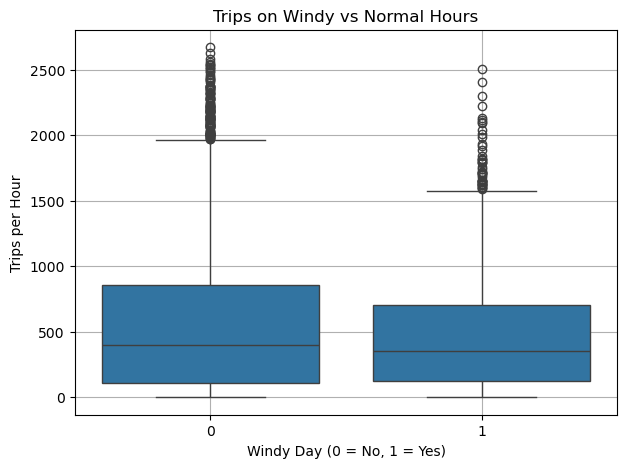

In [87]:
# ----- 1) Compute average trips for windy vs non-windy hours -----
# Group by windy_day (0 = no wind event, 1 = windy) and compute mean trips
mean_trips_by_wind = df_hourly.groupby("windy_day")["trips"].mean()

print("Average trips (normal vs windy):")
print(mean_trips_by_wind)

# Extract values for clarity
avg_no_wind = mean_trips_by_wind[0]   # average trips when windy_day = 0
avg_wind    = mean_trips_by_wind[1]   # average trips when windy_day = 1

# ----- 2) Compute absolute and percentage drop -----
# Absolute difference
diff_abs_wind = avg_no_wind - avg_wind

# Percentage drop relative to normal hours
diff_pct_wind = (diff_abs_wind / avg_no_wind) * 100

print(f"\nAbsolute difference in trips (no wind - windy): {diff_abs_wind:.2f}")
print(f"Percentage drop on windy hours: {diff_pct_wind:.2f}%")

# ----- 3) Create boxplot to visualize wind impact -----
plt.figure(figsize=(7,5))

# Show distribution comparison for windy vs non-windy hours
sns.boxplot(x="windy_day", y="trips", data=df_hourly)

plt.title("Trips on Windy vs Normal Hours")
plt.xlabel("Windy Day (0 = No, 1 = Yes)")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()


In this code, we checked how wind affects bike usage.
First, we calculated the average number of trips during hours with normal wind (0) and hours with strong wind (1).
Then we measured how many trips are lost during windy hours, both as an absolute number and as a percentage drop.
Finally, we plotted a simple boxplot that compares the distribution of trips for windy vs non-windy conditions.
This helps us see clearly whether strong wind reduces bike usage and by how much

### Average trips (normal days vs cold days)


In [141]:
# Compute threshold based on bottom 25% of all temperatures
cold_threshold = df_hourly["2m_temperature"].quantile(0.25)

print("Cold threshold =", cold_threshold)

df_hourly["cold_hour"] = (df_hourly["2m_temperature"] <= cold_threshold).astype(int)


Cold threshold = 3.225601468589378


In this cell, we find the cold temperature threshold by taking the bottom 25% of all temperatures.
Any hour with a temperature below this value is marked as a cold hour (1), and the rest are normal (0).
This helps us compare bike usage on cold vs. normal hours based on the real data.

Average trips (normal vs cold temperature):
cold_hour
0    633.384686
1    247.237443
Name: trips, dtype: float64

Absolute difference (normal - cold): 386.15
Percentage drop on cold hours: 60.97%


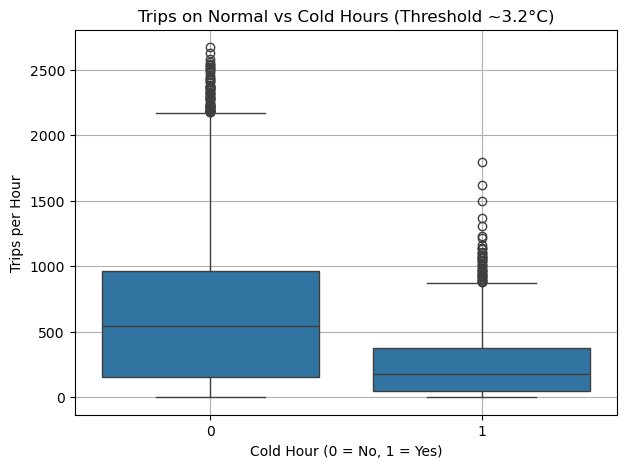

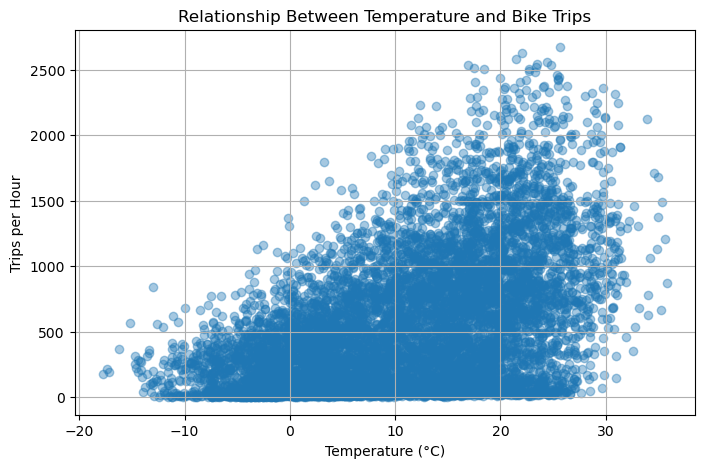

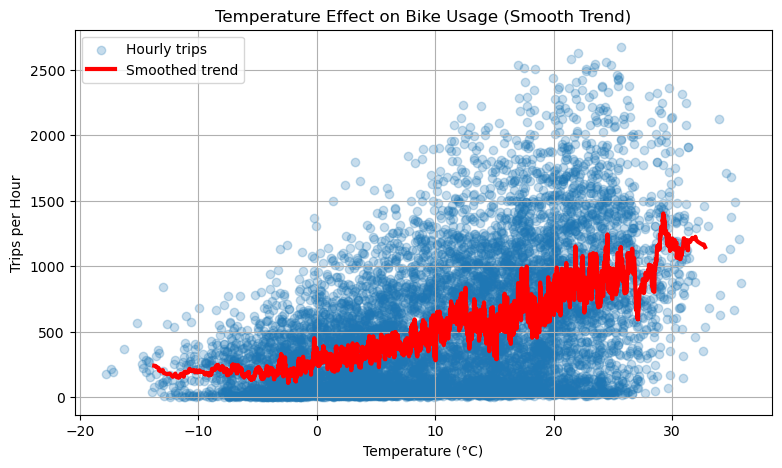

In [149]:
# ----- 1) Use your real cold threshold -----
cold_threshold = 3.2256

# Mark cold hours based on actual temperature threshold
df_hourly["cold_hour"] = (df_hourly["2m_temperature"] <= cold_threshold).astype(int)

# ----- 2) Compute average trips for cold vs normal hours -----
mean_trips_by_temp = df_hourly.groupby("cold_hour")["trips"].mean()

print("Average trips (normal vs cold temperature):")
print(mean_trips_by_temp)

avg_normal_temp = mean_trips_by_temp[0]   # not cold
avg_cold_temp   = mean_trips_by_temp[1]   # cold

# ----- 3) Trip difference -----
diff_abs_temp = avg_normal_temp - avg_cold_temp
diff_pct_temp = (diff_abs_temp / avg_normal_temp) * 100

print(f"\nAbsolute difference (normal - cold): {diff_abs_temp:.2f}")
print(f"Percentage drop on cold hours: {diff_pct_temp:.2f}%")

# ----- 4) Boxplot to visualize -----
plt.figure(figsize=(7,5))
sns.boxplot(x="cold_hour", y="trips", data=df_hourly)

plt.title("Trips on Normal vs Cold Hours (Threshold ~3.2°C)")
plt.xlabel("Cold Hour (0 = No, 1 = Yes)")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))

# Scatterplot to show relationship between temp and trips
plt.scatter(df_hourly["2m_temperature"], df_hourly["trips"], alpha=0.4)

plt.title("Relationship Between Temperature and Bike Trips")
plt.xlabel("Temperature (°C)")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()


# ----- 1) Sort by temperature to make trend line smooth -----
temp_sorted = df_hourly.sort_values("2m_temperature")

# ----- 2) Compute rolling mean (like LOESS but simple) -----
temp_sorted["trips_smooth"] = temp_sorted["trips"].rolling(window=30, center=True).mean()

# ----- 3) Plot -----
plt.figure(figsize=(9,5))

plt.scatter(temp_sorted["2m_temperature"], temp_sorted["trips"],
            alpha=0.25, label="Hourly trips")

plt.plot(temp_sorted["2m_temperature"], temp_sorted["trips_smooth"],
         linewidth=3, label="Smoothed trend", color="red")

plt.title("Temperature Effect on Bike Usage (Smooth Trend)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Trips per Hour")
plt.legend()
plt.grid(True)
plt.show()



### Average trip (per season)

Average trips per season:
season
Fall      706.628663
Spring    487.178976
Summer    708.778533
Winter    240.134259
Name: trips, dtype: float64

==== Season-to-Season Comparison ====
Fall   avg trips : 706.63
Winter avg trips : 240.13
Spring avg trips : 487.18
Summer avg trips : 708.78


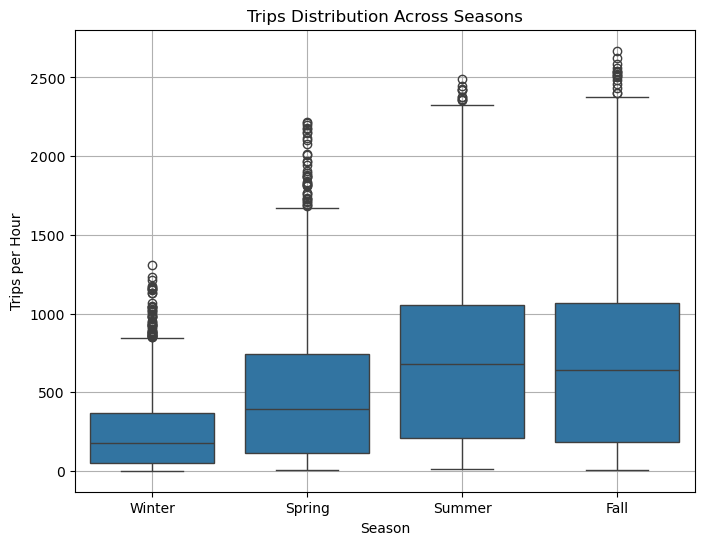

In [201]:
def get_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# We already have 'month' column
df_hourly["season"] = df_hourly["month"].apply(get_season)

# ----- 1) Compute average trips by season -----
mean_trips_by_season = df_hourly.groupby("season")["trips"].mean()

print("Average trips per season:")
print(mean_trips_by_season)

# Convert to variables for clarity
avg_fall   = mean_trips_by_season.get("Fall",   None)
avg_winter = mean_trips_by_season.get("Winter", None)
avg_spring = mean_trips_by_season.get("Spring", None)
avg_summer = mean_trips_by_season.get("Summer", None)

# ----- 2) Print simple comparisons -----
print("\n==== Season-to-Season Comparison ====")
print(f"Fall   avg trips : {avg_fall:.2f}")
print(f"Winter avg trips : {avg_winter:.2f}")
print(f"Spring avg trips : {avg_spring:.2f}")
print(f"Summer avg trips : {avg_summer:.2f}")

# ----- 3) Boxplot to visualize seasonal impact -----
plt.figure(figsize=(8,6))
sns.boxplot(x="season", y="trips", data=df_hourly, order=["Winter", "Spring", "Summer", "Fall"])
plt.title("Trips Distribution Across Seasons")
plt.xlabel("Season")
plt.ylabel("Trips per Hour")
plt.grid(True)
plt.show()


## Prediction

### prepare the Final dataset for train the models in city_level and station_level 

In [10]:
# Quick check: see the first rows of the hourly dataframe
df_hourly.head()

,time_hour,trips,hour,day,weekday,is_weekend,wind_speed,windy_day,total_precipitation,rainy_day,precipitation_type,snowy_day,2m_temperature,is_holiday,month,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-08-01 00:00:00,135,0,1,3,0,4.467081,0,0.128778,0,1.000046,0,23.859295,0,8,False,False,True,False
1,2024-08-01 01:00:00,80,1,1,3,0,4.212774,0,0.647372,1,1.000046,0,23.597325,0,8,False,False,True,False
2,2024-08-01 02:00:00,33,2,1,3,0,4.131097,0,0.731798,1,1.000046,0,23.228444,0,8,False,False,True,False
3,2024-08-01 03:00:00,21,3,1,3,0,4.179396,0,0.233656,0,0.965979,0,23.162022,0,8,False,False,True,False
4,2024-08-01 04:00:00,31,4,1,3,0,3.955337,0,0.003258,0,0.817334,0,23.171896,0,8,False,False,True,False


In [11]:
# --- Create df with station_id + time_hour ---
station_df = df_bike[["time_hour", "start_station_id","end_station_id","start_lat","start_lng"]]

# --- Merge df_hourly with station info ---
station_hourly = df_hourly.merge(
    station_df,
    on="time_hour",
    how="left"
)

print(station_hourly.head())

   time_hour  trips  hour  day  weekday  is_weekend  wind_speed  windy_day  \
0 2024-08-01    135     0    1        3           0    4.467081          0   
1 2024-08-01    135     0    1        3           0    4.467081          0   
2 2024-08-01    135     0    1        3           0    4.467081          0   
3 2024-08-01    135     0    1        3           0    4.467081          0   
4 2024-08-01    135     0    1        3           0    4.467081          0   

   total_precipitation  rainy_day  ...  is_holiday  month  season_Fall  \
0             0.128778          0  ...           0      8        False   
1             0.128778          0  ...           0      8        False   
2             0.128778          0  ...           0      8        False   
3             0.128778          0  ...           0      8        False   
4             0.128778          0  ...           0      8        False   

   season_Spring  season_Summer  season_Winter  start_station_id  \
0          False  

### RandomForest

##### Step 1 — Train / Test split and Select features and target

In [13]:
# Ensure time column is datetime and sort by time
station_hourly["time_hour"] = pd.to_datetime(station_hourly["time_hour"])
station_hourly = station_hourly.sort_values("time_hour")

# Time-based split (80% train, 20% test)
train_ratio = 0.8
split_idx = int(len(station_hourly) * train_ratio)

train = station_hourly.iloc[:split_idx]
test  = station_hourly.iloc[split_idx:]

# Feature columns
feature_cols = [
    "hour",
    "day",
    "weekday",
    "is_weekend",
    "wind_speed",
    "windy_day",
    "total_precipitation",
    "rainy_day",
    "precipitation_type",
    "snowy_day",
    "2m_temperature",
    "is_holiday",
    "month",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter",
]

# Prepare X and y
X_train = train[feature_cols]
y_train = train["trips"]

X_test  = test[feature_cols]
y_test  = test["trips"]


#### Step 2 – Train RandomForestRegressor

In [14]:
# Create and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Step 3 — Make predictions

In [15]:
# Predict trips for test set
y_pred = rf_model.predict(X_test)


#### Step 4 – Evaluate the model (MAE, RMSE, R²)

In [16]:
# Compute evaluation metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Adjusted R-squared
n = X_test.shape[0]        # number of samples
p = X_test.shape[1]        # number of features

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("=== Random Forest Performance (Time-Based Split) ===")
print("MAE        :", round(mae, 2))
print("RMSE       :", round(rmse, 2))
print("R²         :", round(r2, 3))
print("Adj. R²    :", round(adj_r2, 3))

=== Random Forest Performance (Time-Based Split) ===
MAE        : 157.8
RMSE       : 241.69
R²         : 0.77
Adj. R²    : 0.77


#### Step 5 – Plot: True vs Predicted (City Level)

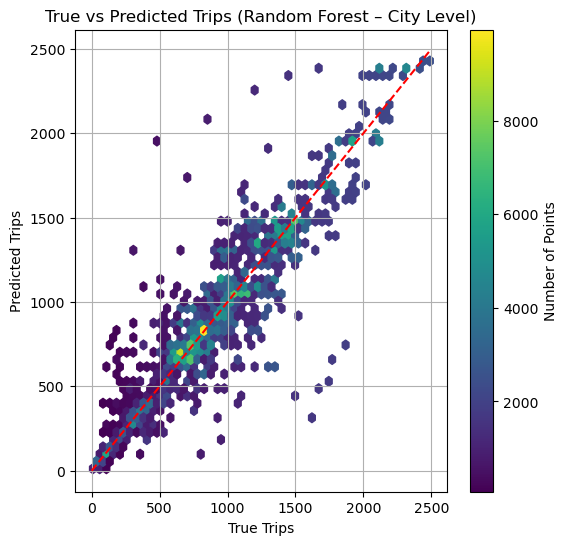

In [17]:

plt.figure(figsize=(6, 6))

plt.hexbin(
    y_test,
    y_pred,          # predictions from Random Forest
    gridsize=50,
    cmap="viridis",
    mincnt=1
)

# Diagonal reference line (perfect prediction)
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")

plt.colorbar(label="Number of Points")

plt.title("True vs Predicted Trips (Random Forest – City Level)")
plt.xlabel("True Trips")
plt.ylabel("Predicted Trips")
plt.grid(True)

plt.show()




#### Extract feature importance from the trained Random Forest

In [18]:
# Get importance values from the trained Random Forest model
importances = rf_model.feature_importances_

# Create a list of feature names
feature_names = feature_cols

# Print feature importance values
for name, value in zip(feature_names, importances):
    print(f"{name}: {value:.4f}")


hour: 0.5055
day: 0.0110
weekday: 0.0523
is_weekend: 0.0316
wind_speed: 0.0154
windy_day: 0.0004
total_precipitation: 0.0212
rainy_day: 0.0009
precipitation_type: 0.0154
snowy_day: 0.0000
2m_temperature: 0.2775
is_holiday: 0.0064
month: 0.0142
season_Fall: 0.0228
season_Spring: 0.0013
season_Summer: 0.0004
season_Winter: 0.0238


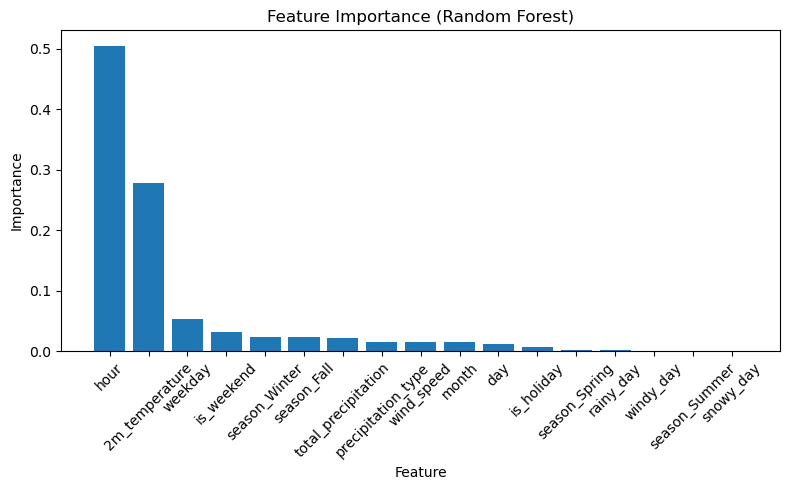

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sort features from most important to least important
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))

# Bar chart of feature importances
plt.bar(range(len(importances)), importances[indices])

# Add feature names under bars
plt.xticks(range(len(importances)),
           [feature_names[i] for i in indices],
           rotation=45)

plt.title("Feature Importance (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


Feature importance shows which inputs affect the prediction the most.
Using Random Forest, we found that some features such as hour of the day, weekend, rain, and wind speed play a strong role in predicting the number of bike trips.
Features with higher importance values contribute more to the model’s decision, meaning that the model relies on them more when predicting the number of trips.

### GradientBoosting

#### Step 1 – Train / Test split

In [20]:
# Ensure time column is datetime and sort by time
station_hourly["time_hour"] = pd.to_datetime(station_hourly["time_hour"])
station_hourly = station_hourly.sort_values("time_hour")

# Time-based split (80% train, 20% test)
train_ratio = 0.8
split_idx = int(len(station_hourly) * train_ratio)

train = station_hourly.iloc[:split_idx]
test  = station_hourly.iloc[split_idx:]

# Feature columns
feature_cols = [
    "hour",
    "day",
    "weekday",
    "is_weekend",
    "wind_speed",
    "windy_day",
    "total_precipitation",
    "rainy_day",
    "precipitation_type",
    "snowy_day",
    "2m_temperature",
    "is_holiday",
    "month",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter",
]

# Prepare X and y
X_train = train[feature_cols]
y_train = train["trips"]

X_test  = test[feature_cols]
y_test  = test["trips"]


#### Step 2 – Train GradientBoostingRegressor

In [21]:
# Create and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)


,loss,'squared_error'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


#### Step 3 — Make predictions (Gradient Boosting)

In [22]:
# Predict trips for test set
y_pred = gb_model.predict(X_test)


#### Step 4 — Evaluate the model (MAE, RMSE, R²) — Gradient

In [29]:

# Compute evaluation metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Adjusted R-squared
n = X_test.shape[0]        # number of samples
p = X_test.shape[1]        # number of features

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("=== Gradient Boosting Performance (Time-Based Split) ===")
print("MAE        :", round(mae, 2))
print("RMSE       :", round(rmse, 2))
print("R²         :", round(r2, 3))
print("Adj. R²    :", round(adj_r2, 3))



=== Gradient Boosting Performance (Time-Based Split) ===
MAE        : 160.64
RMSE       : 214.3
R²         : 0.819
Adj. R²    : 0.819


#### Step 5 — Plot: True vs Predicted (Gradient Boosting)

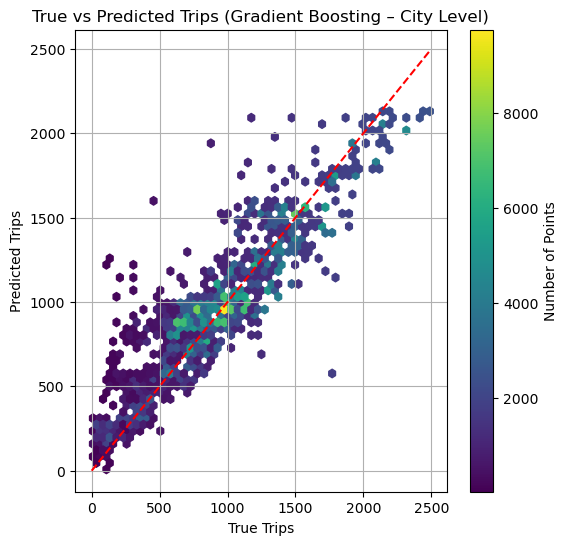

In [24]:
plt.figure(figsize=(6, 6))

plt.hexbin(
    y_test,
    y_pred,          # predictions from Gradient Boosting
    gridsize=50,
    cmap="viridis",
    mincnt=1
)

# Diagonal reference line (perfect prediction)
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")

plt.colorbar(label="Number of Points")

plt.title("True vs Predicted Trips (Gradient Boosting – City Level)")
plt.xlabel("True Trips")
plt.ylabel("Predicted Trips")
plt.grid(True)

plt.show()


#### Extract feature importance from trained Gradient Boosting

In [25]:
# Get importance values from the trained Gradient Boosting model
importances_gb = gb_model.feature_importances_

# Feature names (same list you used earlier)
feature_names = feature_cols

# Print feature importance values
for name, value in zip(feature_names, importances_gb):
    print(f"{name}: {value:.4f}")


hour: 0.5306
day: 0.0049
weekday: 0.0471
is_weekend: 0.0212
wind_speed: 0.0039
windy_day: 0.0000
total_precipitation: 0.0101
rainy_day: 0.0000
precipitation_type: 0.0132
snowy_day: 0.0000
2m_temperature: 0.3043
is_holiday: 0.0016
month: 0.0110
season_Fall: 0.0451
season_Spring: 0.0000
season_Summer: 0.0001
season_Winter: 0.0070


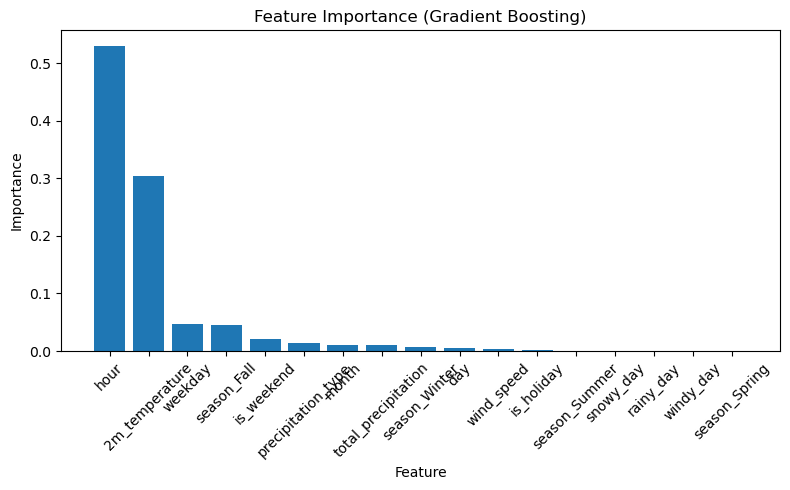

In [26]:

# Sort features from most important to least important
indices_gb = np.argsort(importances_gb)[::-1]

plt.figure(figsize=(8, 5))

# Bar chart of feature importances
plt.bar(range(len(importances_gb)), importances_gb[indices_gb])

# Add feature names
plt.xticks(range(len(importances_gb)),
           [feature_names[i] for i in indices_gb],
           rotation=45)

plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Feature")
plt.ylabel("Importance")

plt.tight_layout()
plt.show()


### XGBoost

#### Step 1 — Train/ Test and Select features and target (XGBoost)

In [27]:
# Ensure time column is datetime and sort by time
station_hourly["time_hour"] = pd.to_datetime(station_hourly["time_hour"])
station_hourly = station_hourly.sort_values("time_hour")

# Time-based split (80% train, 20% test)
train_ratio = 0.8
split_idx = int(len(station_hourly) * train_ratio)

train = station_hourly.iloc[:split_idx]
test  = station_hourly.iloc[split_idx:]

# Feature columns
feature_cols = [
    "hour",
    "day",
    "weekday",
    "is_weekend",
    "wind_speed",
    "windy_day",
    "total_precipitation",
    "rainy_day",
    "precipitation_type",
    "snowy_day",
    "2m_temperature",
    "is_holiday",
    "month",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter",
]

# Prepare X and y
X_train = train[feature_cols]
y_train = train["trips"]

X_test  = test[feature_cols]
y_test  = test["trips"]


#### Step 2 — Train XGBRegressor

In [28]:
# Create and train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### Step 3 — Make predictions (XGBoost)

In [30]:
# Predict trips for test set
y_pred = xgb_model.predict(X_test)


#### Step 4 — Evaluate the model (MAE, RMSE, R²)

In [31]:

# Compute evaluation metrics
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Adjusted R-squared
n = X_test.shape[0]        # number of samples
p = X_test.shape[1]        # number of features

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("=== XGBoost Performance (Time-Based Split) ===")
print("MAE        :", round(mae, 2))
print("RMSE       :", round(rmse, 2))
print("R²         :", round(r2, 3))
print("Adj. R²    :", round(adj_r2, 3))


=== XGBoost Performance (Time-Based Split) ===
MAE        : 127.88
RMSE       : 182.02
R²         : 0.87
Adj. R²    : 0.87


#### Step 5 — Plot: True vs Predicted (XGBoost)

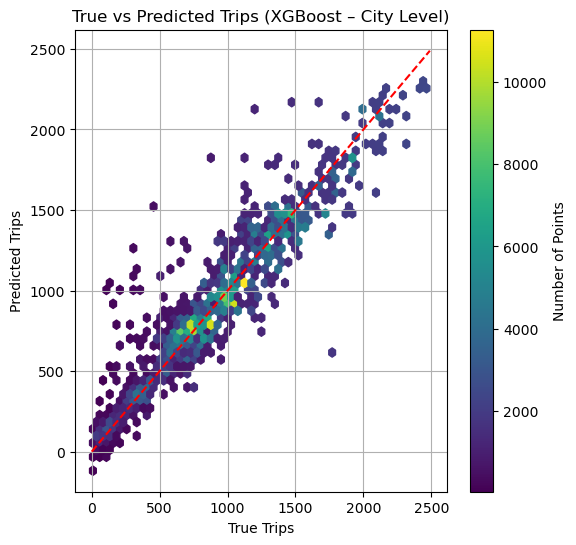

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.hexbin(
    y_test,
    y_pred,
    gridsize=50,
    cmap="viridis",
    mincnt=1
)

# Diagonal reference line
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")

plt.colorbar(label="Number of Points")

plt.title("True vs Predicted Trips (XGBoost – City Level)")
plt.xlabel("True Trips")
plt.ylabel("Predicted Trips")
plt.grid(True)

plt.show()


# station-Level Weather Impact on Bike Usage

## Identify Top 20 Stations

In [33]:
# Cell 2 — Find the top 20 stations with the highest trip count
#  use the ORIGINAL trips dataframe (df_bike), not df_hourly

# Count how many trips started from each station
station_counts = df_bike.groupby("start_station_id")["ride_id"].count()

# Sort by number of trips (descending)
top_20_stations = station_counts.sort_values(ascending=False).head(20).index.tolist()

print("Top 20 stations:", top_20_stations)



Top 20 stations: ['M32006', 'M32011', 'M32042', 'M32018', 'M32041', 'D32016', 'M32037', 'B32005', 'C32008', 'M32085', 'B32016', 'A32010', 'M32005', 'A32002', 'B32065', 'M32061', 'B32002', 'B32062', 'B32034', 'B32015']


This code finds the top 20 busiest stations in the entire bike dataset. It works by counting how many trips started from each station using the original df_bike dataframe. After counting the trips, it sorts the stations from the highest number of trips to the lowest. Finally, it picks the top 20 station IDs and puts them into a list.

In short: the code identifies the 20 stations with the most trips so we can train special fine-tuned models for those stations later.

## Train a Model for Each Station

In [34]:
# Cell 3 — Imports for saving station-specific models
import pickle
from xgboost import XGBRegressor


In [35]:
# ============================================
# Fine-tune City-level XGBoost
# for Top-20 Stations (Time-Based)
# ============================================

import pickle
from xgboost import XGBRegressor
import pandas as pd

# Dictionary to store station-specific models
station_models = {}

# IMPORTANT: must match city-level feature list exactly
feature_cols = [
    "hour",
    "day",
    "weekday",
    "is_weekend",
    "wind_speed",
    "windy_day",
    "total_precipitation",
    "rainy_day",
    "precipitation_type",
    "snowy_day",
    "2m_temperature",
    "is_holiday",
    "month",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter",
]

for station_id in top_20_stations:

    print(f"\n=== Fine-tuning XGBoost for Station {station_id} ===")

    # --------------------------------------------------
    # 1) Filter data for this station
    # --------------------------------------------------
    df_station = station_hourly[
        station_hourly["start_station_id"] == station_id
    ].copy()

    if len(df_station) < 100:
        print("Not enough data, skipping.")
        continue

    # --------------------------------------------------
    # 2) Sort by time and split (80% train / 20% test)
    #    → only TRAIN part is used for fine-tuning
    # --------------------------------------------------
    df_station["time_hour"] = pd.to_datetime(df_station["time_hour"])
    df_station = df_station.sort_values("time_hour")

    split_idx = int(len(df_station) * 0.8)
    train_station = df_station.iloc[:split_idx]

    # --------------------------------------------------
    # 3) Prepare station-level TRAIN features / target
    # --------------------------------------------------
    X_station = train_station[feature_cols].copy()
    y_station = train_station["trips"]

    # Convert boolean columns to int (safety)
    bool_cols = X_station.select_dtypes(include="bool").columns
    for col in bool_cols:
        X_station[col] = X_station[col].astype(int)

    # --------------------------------------------------
    # 4) Create new model with SAME params as city-level
    # --------------------------------------------------
    station_model = XGBRegressor(**xgb_model.get_params())

    # --------------------------------------------------
    # 5) Fine-tune starting from CITY-level model
    # --------------------------------------------------
    station_model.fit(
        X_station,
        y_station,
        xgb_model=xgb_model   
    )

    # --------------------------------------------------
    # 6) Save model
    # --------------------------------------------------
    station_models[station_id] = station_model

    file_name = f"xgb_station_finetuned_{station_id}.pkl"
    with open(file_name, "wb") as f:
        pickle.dump(station_model, f)

    print(f"Saved fine-tuned model: {file_name}")

print("\n✅ All station-level models fine-tuned using CITY-level XGBoost!")



=== Fine-tuning XGBoost for Station M32006 ===
Saved fine-tuned model: xgb_station_finetuned_M32006.pkl

=== Fine-tuning XGBoost for Station M32011 ===
Saved fine-tuned model: xgb_station_finetuned_M32011.pkl

=== Fine-tuning XGBoost for Station M32042 ===
Saved fine-tuned model: xgb_station_finetuned_M32042.pkl

=== Fine-tuning XGBoost for Station M32018 ===
Saved fine-tuned model: xgb_station_finetuned_M32018.pkl

=== Fine-tuning XGBoost for Station M32041 ===
Saved fine-tuned model: xgb_station_finetuned_M32041.pkl

=== Fine-tuning XGBoost for Station D32016 ===
Saved fine-tuned model: xgb_station_finetuned_D32016.pkl

=== Fine-tuning XGBoost for Station M32037 ===
Saved fine-tuned model: xgb_station_finetuned_M32037.pkl

=== Fine-tuning XGBoost for Station B32005 ===
Saved fine-tuned model: xgb_station_finetuned_B32005.pkl

=== Fine-tuning XGBoost for Station C32008 ===
Saved fine-tuned model: xgb_station_finetuned_C32008.pkl

=== Fine-tuning XGBoost for Station M32085 ===
Saved f

This code fine-tunes a separate model for each of the top 20 stations using the global model as a starting point. First, it loops over every station ID in top_20_stations. For each station, it filters the station_hourly dataset to keep only the rows that belong to that station. If there is no data, or if there are too few rows, it skips that station.

Then it builds X_station (the input features) and y_station (the target trips) using the same feature columns that were used for the global model. It also converts any boolean columns to 0/1 so XGBoost can use them. After that, it creates a new XGBoost model with the exact same settings as the global_model, and fine-tunes it by training further on only that station’s data, using xgb_model=global_model as the starting point.

Finally, it saves this fine-tuned model in a dictionary called station_models so you can use it later in code, and also saves each model to a separate .pkl file on disk. In short, this code takes the global model and specializes it into 20 station-specific models.

## Simple Evaluation for 20 Station-Specific Models

In [36]:
# ============================================
# Evaluate station-specific XGBoost models
# using TIME-BASED split
# ============================================

station_results = {}

# Loop through trained station models
for station_id, model in station_models.items():

    print(f"\n=== Evaluating Station {station_id} ===")

    # 1) Get data for this station
    df_station = station_hourly[
        station_hourly["start_station_id"] == station_id
    ].copy()

    if len(df_station) < 100:
        print("Not enough data, skipping.")
        continue

    # 2) Sort by time
    df_station["time_hour"] = pd.to_datetime(df_station["time_hour"])
    df_station = df_station.sort_values("time_hour")

    # 3) Time-based split (80% / 20%)
    split_idx = int(len(df_station) * 0.8)
    train_df = df_station.iloc[:split_idx]
    test_df  = df_station.iloc[split_idx:]

    # 4) Prepare test features/target ONLY
    X_test = test_df[feature_cols].copy()
    y_test = test_df["trips"]

    # Convert boolean columns to int
    bool_cols = X_test.select_dtypes(include="bool").columns
    for col in bool_cols:
        X_test[col] = X_test[col].astype(int)

    # 5) Predict on FUTURE data
    y_pred = model.predict(X_test)

    # 6) Compute metrics
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    # Adjusted R-squared
    n = X_test.shape[0]      # number of test samples
    p = X_test.shape[1]      # number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Save results
    station_results[station_id] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Adj_R2": adj_r2,
        "Test_Samples": len(test_df)
    }

    # Print station results
    print(f"Test samples: {len(test_df)}")
    print("MAE     :", round(mae, 2))
    print("RMSE    :", round(rmse, 2))
    print("R²      :", round(r2, 3))
    print("Adj. R² :", round(adj_r2, 3))

# ============================================
# Summary of all station-level evaluations
# ============================================

print("\n\n==== SUMMARY: Station-level Models (Time-Based Test) ====")

for sid, scores in station_results.items():
    print(
        f"Station {sid} → "
        f"MAE={scores['MAE']:.2f}, "
        f"RMSE={scores['RMSE']:.2f}, "
        f"R²={scores['R2']:.3f}, "
        f"Adj.R²={scores['Adj_R2']:.3f}, "
        f"Test N={scores['Test_Samples']}"
    )



=== Evaluating Station M32006 ===
Test samples: 16950
MAE     : 117.16
RMSE    : 172.67
R²      : 0.877
Adj. R² : 0.876

=== Evaluating Station M32011 ===
Test samples: 12986
MAE     : 124.36
RMSE    : 180.63
R²      : 0.866
Adj. R² : 0.866

=== Evaluating Station M32042 ===
Test samples: 11469
MAE     : 115.06
RMSE    : 177.11
R²      : 0.859
Adj. R² : 0.859

=== Evaluating Station M32018 ===
Test samples: 11272
MAE     : 121.3
RMSE    : 172.85
R²      : 0.873
Adj. R² : 0.873

=== Evaluating Station M32041 ===
Test samples: 8946
MAE     : 117.66
RMSE    : 174.92
R²      : 0.872
Adj. R² : 0.872

=== Evaluating Station D32016 ===
Test samples: 8805
MAE     : 137.61
RMSE    : 192.0
R²      : 0.848
Adj. R² : 0.848

=== Evaluating Station M32037 ===
Test samples: 8684
MAE     : 133.84
RMSE    : 200.32
R²      : 0.867
Adj. R² : 0.867

=== Evaluating Station B32005 ===
Test samples: 7970
MAE     : 118.79
RMSE    : 172.74
R²      : 0.889
Adj. R² : 0.889

=== Evaluating Station C32008 ===
Tes

## Predict trips based on station + features

In [182]:
def predict_trips(station_id, features):
    """
    station_id: ID of the selected station
    features: a single-row DataFrame of input conditions
    """

    # Use station-specific model if available
    if station_id in station_models:
        model = station_models[station_id]
        print(f"Using station-specific model for Station {station_id}")
    else:
        model = xgb_model   # city-level XGBoost
        print("Using GLOBAL city-level XGBoost model")

    prediction = model.predict(features)[0]
    return prediction


This function predicts the number of trips for a station based on the input features you give it. First, it checks whether the station has its own fine-tuned model. If the station is one of the top 20 stations, the function uses that station’s specific model. If not, it falls back to the global model that was trained on all stations.

After choosing the correct model, it takes the feature values (like hour, weather, season, etc.) and uses the model to make a prediction. Finally, it returns the predicted number of trips for that situation.

In short: the function decides which model to use and then outputs the predicted trips for that station and hour.

## Test prediction for any station ID

In [183]:
# Cell 6 — Test prediction for any station ID

# 1) Put the station id you want to test here
test_station_id = "M32037"

# Select a realistic example (latest available record)
if test_station_id in station_hourly["start_station_id"].values:
    row = (
        station_hourly[station_hourly["start_station_id"] == test_station_id]
        .sort_values("time_hour")
        .iloc[-1]
    )
else:
    row = station_hourly.iloc[-1]

feature_cols = [
    "hour",
    "day",
    "weekday",
    "is_weekend",
    "wind_speed",
    "windy_day",
    "total_precipitation",
    "rainy_day",
    "precipitation_type",
    "snowy_day",
    "2m_temperature",
    "is_holiday",
    "month",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter",
]

example_input = pd.DataFrame([row[feature_cols]])

# Convert boolean columns to int
bool_cols = example_input.select_dtypes(include="bool").columns
for col in bool_cols:
    example_input[col] = example_input[col].astype(int)

pred = predict_trips(test_station_id, example_input)

print(f"Station ID: {test_station_id}")
print("Predicted trips:", round(pred, 2))

Using station-specific model for Station M32037
Station ID: M32037
Predicted trips: 469.92


This code is basically a small testing tool that lets us check how many trips the model predicts for any station we choose. First, we type in the station ID we want to test. The code then looks inside the dataset to see if this station exists. If it does, it grabs the first real row of data for that station which includes the hour, weather conditions, and other features for that specific moment.

Next, the code builds a one-row input using all the feature columns that our model needs. After that, it calls the predict_trips function. This function checks if the station is one of the top 20 stations. If yes, it uses the special fine-tuned model for that station. If not, it uses the global model that was trained on the whole city.

Finally, the code prints out the station ID and the predicted number of trips for that hour. In short, this code helps us test how our model behaves for any station under real conditions.

Using station-specific model for Station M32006
=== Test Scenario ===
Station ID : M32006
Hour       : 8  | Weekday: 4  | Month: 10
Season     : Fall=True, Spring=False, Summer=False, Winter=False
Weather    : wind=4.18 m/s, temp=7.4°C, rainy_day=0, total_precip=0.000
Holiday    : 0  | Weekend: 0

=== Prediction ===
Actual trips   : 1252
Predicted trips: 1226.12


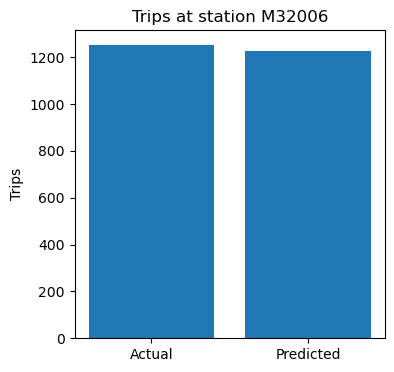

In [191]:
# Cell — Visual test for one station, one hour

import pandas as pd
import matplotlib.pyplot as plt

# 1) Choose test settings manually
test_station_id = "M32006"  # <- change this to any station id you like
test_hour       = 8         # 0–23
test_weekday    = 4         # 0=Mon, 6=Sun
test_month      = 10        # 1–12
test_rainy_day  = 0         # 1 = rainy, 0 = not rainy

# 2) Try to find a real row in station_hourly that matches these conditions
mask = (
    (station_hourly["start_station_id"] == test_station_id) &
    (station_hourly["hour"] == test_hour) &
    (station_hourly["weekday"] == test_weekday) &
    (station_hourly["month"] == test_month) &
    (station_hourly["rainy_day"] == test_rainy_day)
)

if station_hourly[mask].empty:
    # fallback: relax the filter (only station + hour)
    mask = (
        (station_hourly["start_station_id"] == test_station_id) &
        (station_hourly["hour"] == test_hour)
    )

row = station_hourly[mask].sort_values("time_hour").iloc[-1]


# 3) Build a one-row DataFrame of features (same feature_cols as global model)
example_input = pd.DataFrame([row[feature_cols]])

# Convert any boolean columns to int (0/1) to match training format
bool_cols = example_input.select_dtypes(include="bool").columns
for col in bool_cols:
    example_input[col] = example_input[col].astype(int)

# 4) Call the predict_trips function
pred = predict_trips(test_station_id, example_input)
actual = row["trips"]

# 5) Print a nice summary of the test scenario
print("=== Test Scenario ===")
print(f"Station ID : {test_station_id}")
print(f"Hour       : {row['hour']}  | Weekday: {row['weekday']}  | Month: {row['month']}")
print(
    f"Season     : Fall={row['season_Fall']}, "
    f"Spring={row['season_Spring']}, "
    f"Summer={row['season_Summer']}, "
    f"Winter={row['season_Winter']}"
)
print(
    f"Weather    : wind={row['wind_speed']:.2f} m/s, "
    f"temp={row['2m_temperature']:.1f}°C, "
    f"rainy_day={row['rainy_day']}, "
    f"total_precip={row['total_precipitation']:.3f}"
)
print(f"Holiday    : {row['is_holiday']}  | Weekend: {row['is_weekend']}")

print("\n=== Prediction ===")
print(f"Actual trips   : {actual}")
print(f"Predicted trips: {pred:.2f}")

# 6) Simple bar plot: Actual vs Predicted
plt.figure(figsize=(4, 4))
plt.bar(["Actual", "Predicted"], [actual, pred])
plt.ylabel("Trips")
plt.title(f"Trips at station {test_station_id}")
plt.show()


This code is a small testing tool that lets us check how well our model predicts bike trips under real conditions. We choose a station ID, an hour of the day, the weekday, the month, and whether it was rainy or not. The code then searches the dataset to find a real row that matches these conditions. If it finds one, it uses that row as the test example.

Next, it builds the feature input for the model and uses the predict_trips function to make a prediction. Depending on the station, the model may use either the global model or the fine-tuned station-specific model. After that, the code prints a small summary of the conditions like the hour, weather, and season and shows both the actual number of trips and the predicted number.

Finally, it draws a simple bar chart comparing the real trips versus the predicted trips.
In short, this cell helps us visualize and understand how accurate the model is for a specific station, on a specific day and hour, with specific weather conditions.

## Station-Level Weather Sensitivity

In this section, we analyze how each bike station reacts to different weather conditions such as temperature, rain, and wind. Instead of looking at the entire system as one model, we study stations individually to see which ones are more sensitive or more resilient to weather changes. To do this, we run a simple linear regression for every station using hourly trip counts and weather features. The regression coefficients (β-values) show how strongly each weather factor affects bike usage at that specific location. This helps us identify patterns, compare stations, and understand which areas of the city are more impacted by weather.

### Prepare Data for Station-Level Weather Regression

In [192]:
# Select only columns needed for sensitivity regression
cols_needed = [
    "start_station_id",
    "trips",
    "2m_temperature",
    "total_precipitation",
    "wind_speed"
]

df_sens = station_hourly[cols_needed].copy()

# Drop missing values to avoid regression errors
df_sens = df_sens.dropna()

print(df_sens.head())
print("Rows:", len(df_sens))


   start_station_id  trips  2m_temperature  total_precipitation  wind_speed
0            D32017    135       23.859295             0.128778    4.467081
69           D32008    135       23.859295             0.128778    4.467081
99           C32009    135       23.859295             0.128778    4.467081
98           D32032    135       23.859295             0.128778    4.467081
97           M32070    135       23.859295             0.128778    4.467081
Rows: 4702154


### Define Regression Function for Each Station

In [198]:

def fit_station_regression(df_station):
    """
    Fit simple linear regression:
    trips ~ temp + rain + wind
    """
    X = df_station[["2m_temperature", "total_precipitation", "wind_speed"]]
    y = df_station["trips"]
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Extract coefficients
    result = {
        "beta_temp": model.coef_[0],
        "beta_rain": model.coef_[1],
        "beta_wind": model.coef_[2],
        "intercept": model.intercept_,
        "r2": r2,
        "n_samples": len(df_station)
    }
    
    return result


### Run Regression for All Stations and Collect Sensitivity Scores

In [199]:
MIN_SAMPLES = 40   # skip stations with very few records

results = []

# Loop over each station
for station_id, df_group in df_sens.groupby("start_station_id"):
    if len(df_group) < MIN_SAMPLES:
        continue
    
    stats = fit_station_regression(df_group)
    stats["start_station_id"] = station_id
    results.append(stats)

station_sensitivity = pd.DataFrame(results)

# Reorder columns
station_sensitivity = station_sensitivity[
    ["start_station_id", "n_samples", "beta_temp", "beta_rain", "beta_wind", "intercept", "r2"]
]

station_sensitivity = station_sensitivity.dropna(subset=["start_station_id"])


station_sensitivity.head()


,start_station_id,n_samples,beta_temp,beta_rain,beta_wind,intercept,r2
0,<NA>,1591,28.335824,-167.058149,-24.953078,626.758080,0.296179
1,A32000,9520,28.286218,-131.112079,-3.734747,629.300162,0.213149
2,A32001,15436,27.326634,-156.888033,-18.310318,599.783303,0.244606
3,A32002,35620,31.898550,-163.654781,-13.995746,533.418954,0.282512
4,A32003,16753,32.690515,-192.455587,-10.773021,558.334432,0.307004


### Find the Stations Most Affected by Rain

In [202]:
# Title: Common Setup for Station Maps

# 1) Build unique station coordinates from station_hourly
station_locations = (
    station_hourly[["start_station_id", "start_lat", "start_lng"]]
    .dropna()                          # remove rows with missing coords
    .drop_duplicates(subset="start_station_id")  # one row per station
)

print("Station locations sample:")
print(station_locations.head())


# 3) Helper function to plot Top 10 stations on a map
def plot_top10_map(top10_df, value_col, title_text):
    """
    Plot Top 10 stations on a map.
    top10_df : dataframe with start_station_id + beta_* columns
    value_col: column name to show in popup (e.g. 'beta_rain')
    title_text: just a text label for understanding
    """
    # Merge with coordinates
    top10_geo = top10_df.merge(
        station_locations,
        on="start_station_id",
        how="inner"
    )

    # Center of the map = mean of station coordinates
    center_lat = top10_geo["start_lat"].mean()
    center_lng = top10_geo["start_lng"].mean()

    # Create base map
    m = folium.Map(location=[center_lat, center_lng], zoom_start=13)

    # Add each station as a red circle
    for _, row in top10_geo.iterrows():
        val = row[value_col]
        folium.CircleMarker(
            location=[row["start_lat"], row["start_lng"]],
            radius=10,           # bigger so it is visible
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.9,
            popup=f"Station: {row['start_station_id']}<br>{value_col}: {val:.2f}"
        ).add_to(m)

    # Show the map
    return m


Station locations sample:
   start_station_id  start_lat  start_lng
0            D32017  42.355536 -71.072869
69           D32008  42.357143 -71.050699
99           C32009  42.344041 -71.057376
98           D32032  42.349496 -71.100576
97           M32070  42.360542 -71.086698


#### Find the Most Rain-Sensitive Stations

In [203]:
station_sensitivity.sort_values("beta_rain").head(10)

# Find the Stations Most Affected by Rain
top10_rain_sensitive = station_sensitivity.sort_values("beta_rain").head(10)
top10_rain_sensitive
print(top10_rain_sensitive)

# Map for Top 10 Rain-Sensitive Stations
plot_top10_map(top10_rain_sensitive, "beta_rain", "Top 10 Rain-Sensitive Stations")





    start_station_id  n_samples  beta_temp   beta_rain  beta_wind   intercept        r2
535           T32017        115  21.416416 -984.919163  32.111488  648.968773  0.238628
389           M32028        212  22.782097 -795.688625 -19.918116  719.630549  0.095876
113           C23045        300  21.748027 -622.120121  -3.623239  655.753242  0.127409
114           C23109        147  27.511315 -586.859404 -18.666176  760.066123  0.217820
527           T32009        414  38.668885 -310.740942   6.282050  544.226104  0.400458
324           F32011        484  31.698786 -298.758512  -7.733659  554.057605  0.322998
520           T32002        978  21.969734 -293.360738   3.990889  752.425391  0.099227
519           T32001        579  24.138096 -292.359669   5.080158  706.088888  0.103376
293           D32070        237  24.811279 -284.541078 -15.725921  706.084885  0.127835
522           T32004       1275  30.663627 -280.075390  -4.514443  569.999934  0.207133


This cell finds the stations where rain has the strongest negative effect on bike trips.
A more negative beta_rain means “when rain increases, trips drop a lot.”
So these are the stations most sensitive to rainy weather.

#### Find the Most Rain-Resilient Stations

In [204]:
# Find the Most Rain-Resilient Stations
top10_rain_resilient = station_sensitivity.iloc[
    station_sensitivity["beta_rain"].abs().argsort()
].head(10)
print(top10_rain_resilient)

# Map for Top 10 Rain-Resilient Stations
plot_top10_map(top10_rain_resilient, "beta_rain", "Top 10 Rain-Resilient Stations")



    start_station_id  n_samples  beta_temp  beta_rain   beta_wind   intercept        r2
536           T32018       1163  27.800505  -0.558446   -9.826642  635.426304  0.122611
187           C32076       1205  26.422374  -1.146758  -11.479949  502.856094  0.058545
193           C32082       1224  25.368491  -4.000463  -18.628522  584.740165  0.087009
224           C32115        639  24.057500   5.063836  -15.392044  596.896735  0.048100
314           E32018         88  25.007018   5.563091  -35.431920  603.786922  0.138481
296           D32073         43  18.927751  11.142794 -174.163126  857.688096  0.163282
15            A32015        252  19.857203  17.216374  -68.202350  964.031869  0.069103
62            A32068        500  23.857090 -18.899056    1.486354  565.286886  0.079342
249           D32025       1810  26.836860 -20.259865   -4.906259  412.845557  0.214179
332           G32004        289  30.327463  22.280291  -14.567996  445.187117  0.111080


This cell finds stations where rain does not change bike usage very much.
We look for stations where beta_rain is close to zero.
These stations are “weather-resilient” because riders keep using them even when it rains.

### Find the Stations Most Affected by Temperature

In [205]:
# Find the Stations Most Affected by Temperature
top10_temp = station_sensitivity.sort_values("beta_temp", ascending=False).head(10)
print(top10_temp)
# Map for Top 10 Temperature-Sensitive Stations
plot_top10_map(top10_temp, "beta_temp", "Top 10 Temperature-Sensitive Stations")



    start_station_id  n_samples  beta_temp   beta_rain   beta_wind   intercept        r2
295           D32072        139  59.225319  243.881858   48.608820 -531.528154  0.184392
334           G32006        113  48.113364 -178.573044 -179.574702  386.361088  0.237812
298           E32002        254  44.580086  307.097713  -59.431939  253.137394  0.160177
475           R32004        277  44.372199  500.533016 -115.600791  457.306054  0.200710
562           X32999        428  43.994685 -157.710776    1.877373  468.932231  0.449541
430           M32069        972  42.710077 -267.910184   -5.809853  627.790350  0.384314
530           T32012        391  42.050175 -248.954408   17.057125  334.168475  0.295101
564           Z32998       9925  41.430065 -174.429330    1.990370  541.198877  0.370121
398           M32037      43420  40.241042 -196.114664   -2.390188  602.815491  0.322444
5             A32004      26292  39.328417 -205.051513   -0.568046  570.837644  0.305533


This cell finds which stations show a strong positive relationship with temperature.
A larger beta_temp means “when the temperature goes up, bike usage increases a lot.”
These stations are sensitive to warm weather

### Find the Stations Most Affected by Wind

In [206]:
# Find the Stations Most Affected by Wind
top10_wind = station_sensitivity.sort_values("beta_wind").head(10)
print(top10_wind)

# Map for Top 10 Wind-Sensitive Stations
plot_top10_map(top10_wind, "beta_wind", "Top 10 Wind-Sensitive Stations")


    start_station_id  n_samples  beta_temp   beta_rain   beta_wind   intercept        r2
334           G32006        113  48.113364 -178.573044 -179.574702  386.361088  0.237812
296           D32073         43  18.927751   11.142794 -174.163126  857.688096  0.163282
475           R32004        277  44.372199  500.533016 -115.600791  457.306054  0.200710
294           D32071        276  37.357230  115.764439  -69.126674  460.587333  0.097297
15            A32015        252  19.857203   17.216374  -68.202350  964.031869  0.069103
298           E32002        254  44.580086  307.097713  -59.431939  253.137394  0.160177
246           D32022       4157  28.253782 -179.498749  -46.323598  978.987056  0.230949
205           C32094        156  17.800447   27.757882  -45.493044  804.005496  0.110434
110           B32068       2853  35.051100   51.476484  -44.360627  404.138694  0.086139
532           T32014        311  25.480949 -165.397495  -43.321862  816.700613  0.192202


Here we find stations where wind has a strong negative effect on bike trips.
A more negative beta_wind means “strong wind discourages people from riding.”
These stations are the most wind-sensitive.

## Station Clustering Based on Weather-Related Behavior


In this section, we group bike stations based on how they behave under different weather conditions such as rain, wind, and temperature. The goal is to discover meaningful patterns and identify station types, such as rain-sensitive, resilient, or always-busy central stations.

### Build Aggregated Weather-Behavior Features for Each Station

In [207]:
# Title: Build Aggregated Features for Each Station

df = station_hourly.copy()

# --- Feature 1: avg trips on rainy hours ---
rainy = df[df["rainy_day"] == 1].groupby("start_station_id")["trips"].mean()
rainy = rainy.rename("avg_trips_rain")

# --- Feature 2: avg trips on dry hours ---
dry = df[df["rainy_day"] == 0].groupby("start_station_id")["trips"].mean()
dry = dry.rename("avg_trips_dry")

# --- Feature 3: difference (rain impact) ---
rain_impact = (dry - rainy).rename("rain_impact")

# --- Feature 4: avg trips on windy days ---
windy = df[df["windy_day"] == 1].groupby("start_station_id")["trips"].mean()
windy = windy.rename("avg_trips_windy")

# --- Feature 5: temperature sensitivity (simple) ---
temp_sens = df.groupby("start_station_id")["2m_temperature"].mean()
temp_sens = temp_sens.rename("avg_temp")

# Combine all features into one table
station_features = pd.concat([rainy, dry, rain_impact, windy, temp_sens], axis=1)

# Drop stations with missing data
station_features = station_features.dropna()

station_features.head()


,avg_trips_rain,avg_trips_dry,rain_impact,avg_trips_windy,avg_temp
start_station_id,,,,,
<NA>,692.365591,977.417223,285.051632,788.034364,15.366139
A32000,985.532290,1104.572983,119.040693,993.254483,17.344891
A32001,720.484135,927.021786,206.537651,790.213603,14.321718
A32002,725.801691,958.838551,233.036859,818.536741,14.829423
A32003,726.216245,1005.466498,279.250253,847.083911,14.797559



This cell creates summary features for each station, such as average trips on rainy hours, dry hours, windy hours, and temperature levels. These features help us describe each station’s behavior in a compact form for clustering.

### Normalize Features Before Clustering

In [208]:
# Title: Normalize Features for Clustering

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_features)

X_scaled[:5]  # show first 5 rows


array([[-1.03807619, -0.58748812,  0.82364923, -1.09008495, -0.20296012],
       [ 1.51829262,  0.90340615, -1.15969039,  0.78771461,  0.69709242],
       [-0.79288678, -1.17837184, -0.11436058, -1.07014453, -0.67802432],
       [-0.74651851, -0.80532203,  0.20222657, -0.81098293, -0.44709046],
       [-0.74290366, -0.25861192,  0.75433992, -0.54977139, -0.46158381]])


We scale all numeric features so that they have similar ranges. This prevents K-Means from being dominated by large-value features and ensures fair clustering.

### Run K-Means to Assign Cluster Labels to Stations

In [209]:
# Title: Run K-Means Clustering on Stations

from sklearn.cluster import KMeans

k = 3  # you can try 3, 4, 5 clusters
kmeans = KMeans(n_clusters=k, random_state=42)

station_features["cluster"] = kmeans.fit_predict(X_scaled)

station_features.head()


,avg_trips_rain,avg_trips_dry,rain_impact,avg_trips_windy,avg_temp,cluster
start_station_id,,,,,,
<NA>,692.365591,977.417223,285.051632,788.034364,15.366139,0
A32000,985.532290,1104.572983,119.040693,993.254483,17.344891,2
A32001,720.484135,927.021786,206.537651,790.213603,14.321718,0
A32002,725.801691,958.838551,233.036859,818.536741,14.829423,0
A32003,726.216245,1005.466498,279.250253,847.083911,14.797559,0



This cell applies the K-Means algorithm to group stations into clusters. Each station receives a cluster label (0, 1, 2…) based on its weather-related behavior.

### Scatter Plot of Stations in Feature Space

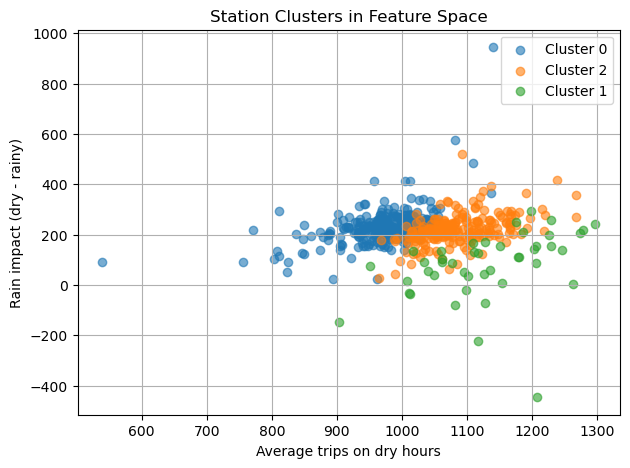

In [210]:
# Title: Scatter Plot of Stations by Features and Cluster

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

# scatter of stations in feature space
for c in station_features["cluster"].unique():
    subset = station_features[station_features["cluster"] == c]
    plt.scatter(
        subset["avg_trips_dry"],
        subset["rain_impact"],
        label=f"Cluster {c}",
        alpha=0.6
    )

plt.xlabel("Average trips on dry hours")
plt.ylabel("Rain impact (dry - rainy)")
plt.title("Station Clusters in Feature Space")
plt.legend()
plt.grid(True)
plt.show()



This plot shows all stations in a two-feature space (dry-hour trips vs. rain impact).
It helps us visually understand how stations group into different clusters based on their behavior.

### Boxplot of Rain Impact by Cluster

<Figure size 600x400 with 0 Axes>

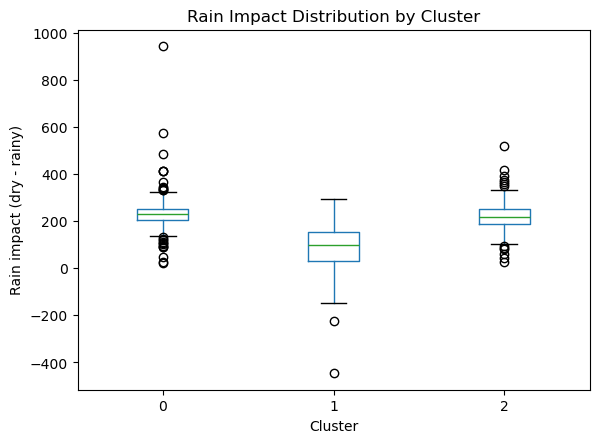

In [211]:
# Title: Boxplot of Rain Impact by Cluster

plt.figure(figsize=(6, 4))
station_features.boxplot(
    column="rain_impact",
    by="cluster",
    grid=False
)
plt.title("Rain Impact Distribution by Cluster")
plt.suptitle("")  # remove automatic title
plt.xlabel("Cluster")
plt.ylabel("Rain impact (dry - rainy)")
plt.show()



This boxplot compares how much rain affects each cluster.
It helps us see which cluster is most rain-sensitive and which cluster is more resilient.